In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [62]:
sr_path = Path(ROOT_DIR, 'results', 'sr')
r_path = Path(ROOT_DIR, 'results', 'r')
pr_path = Path(ROOT_DIR, 'results', 'pr')
split_pr_by = ["update_weight_interval"]
pr_colors = ['dimgray', 'darkgray', 'lightgray']

def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [51]:
load_info([p for p in sr_path.iterdir()][0])['args'].item()

{'results_fname': '596d698c647b7d48c7da9f2a02831887_Thu Jul 15 09:46:47 2021.npy',
 'total_steps': 20000,
 'random_start': True,
 'results_dir': PosixPath('/scratch/taodav/uncertainty/results/sr'),
 'env': 'sr',
 'seed': 2020,
 'device': device(type='cpu'),
 'step_size': 0.0001,
 'epsilon': 0.1,
 'log_dir': PosixPath('/scratch/taodav/uncertainty/log/sr'),
 'n_hidden': 100,
 'update_weight_interval': 1,
 'max_episode_steps': 1000,
 'discounting': 0.9,
 'blur_prob': 0.3}

In [55]:
def process_dir(dir_path, key="reward", w=100, trunc=20000, split_by=None):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            result = moving_avg(info[key][:trunc], w=w)
            all_results[split_by_tuple][hparams].append(result)
            
        else:
            result = moving_avg(info[key][:trunc], w=w)
            all_results.append(result)
    if split_by is not None:
        for k, v in all_results.items():
            for k1, v1 in v.items():
                all_results[k][k1] = np.array(all_results[k][k1])
        data = all_results
    else:
        data = np.array(all_results)

    
    return data


In [56]:
w = 100
sr_data = process_dir(sr_path, w=w)
r_data = process_dir(r_path, w=w)
pr_data = process_dir(pr_path, w=w, split_by=split_pr_by)

In [61]:
pr_uwi_data = pr_data[('update_weight_interval',)]

In [73]:
all_data = [('State + obs', sr_data, 'blue'), ('Obs only', r_data, 'orange')] 
#             *[(f"PF + obs (update every {k[0]})", d, pr_colors[i]) for i, (k, d) in enumerate(pr_uwi_data.items())]]
# all_data = [(f"PF + obs (update every {k[0]})", d, pr_colors[i]) for i, (k, d) in enumerate(pr_uwi_data.items())]

In [74]:
all_data

[('State + obs',
  array([[0.  , 0.  , 0.  , ..., 0.14, 0.14, 0.14],
         [0.  , 0.  , 0.  , ..., 0.07, 0.07, 0.07],
         [0.  , 0.  , 0.  , ..., 0.11, 0.1 , 0.1 ],
         ...,
         [0.  , 0.  , 0.  , ..., 0.03, 0.03, 0.03],
         [0.  , 0.  , 0.  , ..., 0.12, 0.12, 0.12],
         [0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.06]]),
  'blue'),
 ('Obs only',
  array([[0.  , 0.  , 0.  , ..., 0.05, 0.05, 0.05],
         [0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.06],
         [0.02, 0.02, 0.02, ..., 0.04, 0.03, 0.03],
         ...,
         [0.01, 0.01, 0.01, ..., 0.05, 0.05, 0.05],
         [0.01, 0.01, 0.01, ..., 0.04, 0.04, 0.04],
         [0.01, 0.01, 0.  , ..., 0.06, 0.06, 0.06]]),
  'orange')]

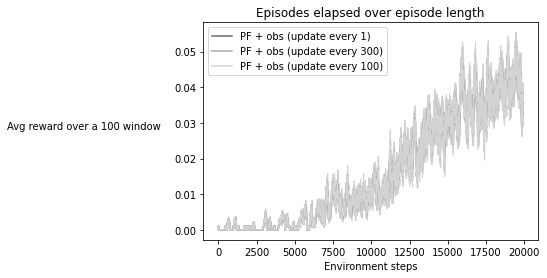

In [72]:
x = np.arange(sr_data.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Avg reward over a {w} window", rotation=0, labelpad=90)
ax.set_title('Episodes elapsed over episode length')
plt.legend()

In [41]:
std_err

array([0.00039189, 0.00039189, 0.00039205, ..., 0.00076731, 0.00074998,
       0.00075882])